In [1]:
from pyzabbix import ZabbixAPI
import pandas as pd
import re
import pytz
import datetime
import time
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
load_dotenv()

True

In [161]:
#--------------  connected PG ----------------#
system_info_config = {
    'host' : os.environ.get("SYSTEM_INFO_HOST"),
    'port' : os.environ.get("SYSTEM_INFO_PORT"),
    'user' : os.environ.get("SYSTEM_INFO_USER"),
    'password' : os.environ.get("SYSTEM_INFO_PASS"),
    'database' : os.environ.get("SYSTEM_INFO_DB")
}
print(system_info_config)

db_connection_url = f"postgresql://{system_info_config['user']}:{system_info_config['password']}@{system_info_config['host']}:{system_info_config['port']}/{system_info_config['database']}"
conn = create_engine(db_connection_url)
sql = "select * from server_info"
df_sever_info = pd.read_sql_query(sql, conn)
df_sever_info

{'host': '10.10.10.200', 'port': '5432', 'user': 'system', 'password': 'FJNCEHfV', 'database': 'system'}


,server_name,ip_address,hostname,server_type,operating_system,services_software,cpu_total,cpu_unit,memory_total,memory_unit,disk_total,disk_unit
0,360-Webserver-01,10.10.10.22,web1.bigdata.local,Virtual Server,Ubuntu 20.04 LTS,"Frontend , Nginx",8,core,8,GB,250,GB
1,360-Webserver-02,10.10.10.23,web2.bigdata.local,Virtual Server,Ubuntu 20.04 LTS,"Frontend , Nginx",8,core,8,GB,250,GB
2,Big Data Data node 1,10.10.10.14,cdhdn1.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
3,Big Data Data Node 2,10.10.10.15,cdhdn2.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
4,Big Data Data Node 3,10.10.10.16,cdhdn3.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
5,CDH6-Master-Node-1,10.10.10.200,cdhmn1.bigdata.local,Virtual Server,Centos 7.9,"CM, Hue, Atlas, Ranger, Hive",16,core,64,GB,250,GB


In [163]:
#--------------  Hostname/Hostid ----------------#
zapi = ZabbixAPI("http://10.10.10.20/zabbix")
hosts = zapi.host.get() #method host.get for hostid and hostname
#get host_id, host_ip and host_name
df_host = pd.DataFrame(hosts)
df_host = df_host.merge(df_sever_info, left_on= 'host', right_on= 'ip_address') # merge with vm that exist in sever
df_host = df_host.filter(items=['hostid', 'host','name']).drop_duplicates()

#-------------- Itemid ----------------#
data_item = zapi.item.get() #method item.get for itemid (this method return only lastest data)
# get item data
df = pd.DataFrame(data_item)

#-------------- Merge ----------------#
#marge host and items to match hostid and itemid
df_merge = df_host.merge(df, left_on='hostid', right_on='hostid')
df_merge = df_merge.rename(columns={"name_x": "host_name", "name_y": "item_name"})

#-------------- Clean and change datetime type ----------------#
# select row and drop column
df_main = df_merge[df_merge['item_name'].str.contains('utilization', flags=re.IGNORECASE, regex=True)] # got item_name that contains only disk,cpu and memory (case-insensitive)
df_main =  df_main[['hostid','host','host_name','itemid','item_name','history','trends','lastclock','units','lastvalue','prevvalue','description']] #selected only columns we want
df_main['lastclock'] = df_main['lastclock'].astype('int').astype("datetime64[s]").dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok') # change UNIXTIME to local datetime(UTC) and convert to local Bangkok time zone

#-----------------  selected word that contains only CPU utilizarion -------------------#
df_cpu = df_main[df_main['item_name'].str.contains('CPU utilization', flags=re.IGNORECASE, regex=True)] #find itemid for CPU utilization
df_cpu = df_cpu.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

#-----------------  selected word that contains only Memory Utilizaiton -------------------#
df_mem = df_main[df_main['item_name'].str.contains('memory utilization', flags=re.IGNORECASE, regex=True)]#find itemid for memory utilization
df_mem = df_mem.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

#----------------- selected word that contains only disk Utilizaiton -------------------#
df_disk = df_main[df_main['item_name'].str.contains('disk utilization', flags=re.IGNORECASE, regex=True)]#find itemid for disk utilization
df_disk = df_disk.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

df_cpu_mem_disk = pd.concat([df_cpu, df_mem, df_disk], ignore_index=True)


#select period for accessing historical data
start_date = datetime.datetime.today().replace(day=1, hour=0, minute=0, second=1, microsecond=0) #first day of month
end_date = datetime.datetime.today() 
start_unix = time.mktime(start_date.timetuple()) #start date
end_unix = time.mktime(end_date.timetuple()) #end date
print(f"start_date : {start_date} >>  start_unix : {start_unix}")
print(f"end_date : {end_date} >> end_unix : {end_unix}")

#get trend data
method = "trend.get"  # trend.get will return hourly historical data 
params = {
        "itemids" : df_cpu_mem_disk['itemid'].tolist(),
        "time_from": int(start_unix), # start date
        "time_till": int(end_unix), # end date
}
result = zapi.do_request( method,params=params)
    
df_trend = pd.DataFrame(result['result'])
df_trend['clock'] = df_trend['clock'].astype('int').astype("datetime64[s]").dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok') #change unix data to local time
df_trend['value_avg'] = df_trend['value_avg'].astype(float) #change data type




start_date : 2024-01-01 00:00:01 >>  start_unix : 1704042001.0
end_date : 2024-01-03 16:48:02.995111 >> end_unix : 1704275282.0


In [5]:
#-----------------  avg monthly cpu -------------------#
df_cpu_trend_avg_month = df_trend.copy()
df_cpu_trend_avg_month = df_cpu_trend_avg_month.merge(df_cpu, left_on='itemid', right_on='itemid')
df_cpu_trend_avg_month['mean_value'] = df_cpu_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_cpu_trend_avg_month = df_cpu_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_cpu_trend_avg_month['label'] = "cpu_trend_avg_month"

#-----------------  avg monthly mem -------------------#
df_mem_trend_avg_month = df_trend.copy()
df_mem_trend_avg_month = df_mem_trend_avg_month.merge(df_mem, left_on='itemid', right_on='itemid')
df_mem_trend_avg_month['mean_value'] = df_mem_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_mem_trend_avg_month = df_mem_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_mem_trend_avg_month['label'] = "mem_trend_avg_month"

#-----------------  avg monthly disk -------------------#
df_disk_trend_avg_month = df_trend.copy()
df_disk_trend_avg_month = df_disk_trend_avg_month.merge(df_disk, left_on='itemid', right_on='itemid')
df_disk_trend_avg_month['mean_value'] = df_disk_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_disk_trend_avg_month = df_disk_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_disk_trend_avg_month['label'] = "disk_trend_avg_month"


In [6]:
#-----------------  avg daily cpu -------------------#
df_cpu_trend_avg_day = df_trend.copy()
df_cpu_trend_avg_day ['day']  = df_cpu_trend_avg_day['clock'].dt.day.values
df_cpu_trend_avg_day['mean_value'] = df_cpu_trend_avg_day.groupby(['itemid','day'])['value_avg'].transform(np.mean)
df_cpu_trend_avg_day = df_cpu_trend_avg_day.merge(df_cpu, left_on='itemid', right_on='itemid')
df_cpu_trend_avg_day = df_cpu_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_cpu_trend_avg_day['label'] = 'cpu_trend_avg_day' 

#-----------------  avg daily mem -------------------#
df_mem_trend_avg_day = df_trend.copy()
df_mem_trend_avg_day ['day']  = df_mem_trend_avg_day['clock'].dt.day.values
df_mem_trend_avg_day['mean_value'] = df_mem_trend_avg_day.groupby(['itemid','day'])['value_avg'].transform(np.mean)
df_mem_trend_avg_day = df_mem_trend_avg_day.merge(df_mem, left_on='itemid', right_on='itemid')
df_mem_trend_avg_day = df_mem_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_mem_trend_avg_day['label'] = 'mem_trend_avg_day'

#-----------------  avg daily disk -------------------#
df_disk_trend_avg_day = df_trend.copy()
df_disk_trend_avg_day ['day']  = df_disk_trend_avg_day['clock'].dt.day.values
df_disk_trend_avg_day = df_disk_trend_avg_day.merge(df_disk, left_on='itemid', right_on='itemid')
df_disk_trend_avg_day['mean_value'] = df_disk_trend_avg_day.groupby(['hostid','day'])['value_avg'].transform(np.mean)
df_disk_trend_avg_day = df_disk_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_disk_trend_avg_day['label'] = 'disk_trend_avg_day'

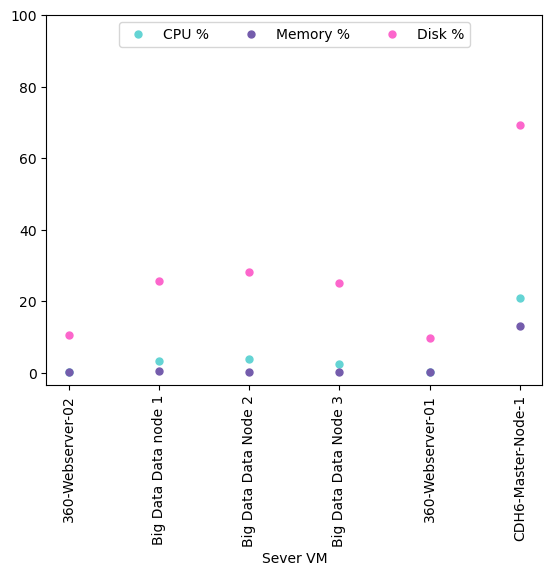

In [159]:
#-----------------  monthly trend chart -------------------#
df_avg_month = pd.concat([df_cpu_trend_avg_month, df_mem_trend_avg_month,df_disk_trend_avg_month], ignore_index=True)

groups = df_avg_month.groupby('label')

# Plot
fig, ax = plt.subplots()

colors = {"cpu_trend_avg_month": '#64d4d4', "mem_trend_avg_month": '#fc66cc',"disk_trend_avg_month": '#745cac'}
for name, group in groups:
    ax.plot(group.host_name, group.mean_value, marker='o', linestyle='', ms=5, label=name , c= colors[name])

legend_labels = ['CPU %', 'Memory %', 'Disk %'] # set legend
ax.legend(labels = legend_labels,loc='upper center',ncol=3) # add legend
plt.xticks(rotation=90)  # rotate text on x-axis to 90 degree
plt.xlabel("Sever VM") # add x label
plt.margins(x=0.05) # adds 5% padding to the autoscaling
plt.yticks(np.arange(0, 120, 20)) # set y-tick freq.
plt.savefig(f'./image/monthly_trend_chart.png', bbox_inches='tight') #save image
plt.show()

In [158]:
def text_status_th(percent): # add status_th function
    if percent > 85:
       text = "ระบบทำงานหนัก"
    elif percent < 75:
        text = "ปกติ"
    else: text = "ระบบมีความเสี่ยงสมควรเฝ้าระวัง"
    return text 

def text_status(percent): # add status function
    if percent > 85:
       text = "critical status"
    elif percent < 75:
        text = "normal status"
    else: text = "warning status"
    return text 

#-----------------  add status -------------------#
df_avg_month["status"] = df_avg_month["mean_value"].apply(lambda x : text_status(x))
df_cpu_trend_avg_month["status"] = df_cpu_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
df_mem_trend_avg_month["status"] = df_mem_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
df_disk_trend_avg_month["status"] = df_disk_trend_avg_month["mean_value"].apply(lambda x : text_status(x))


#-----------------  overall utilizaiton -------------------#
lst = []
dictt = {}

dictt["vm_total"] = len(df_avg_month.filter(items=['host_name']).drop_duplicates())
dictt["normal status"]  = len(df_avg_month[df_avg_month["status"] == "normal status"])
dictt["warning status"] = len(df_avg_month[df_avg_month["status"] == "warning status"])
dictt["critical status"] = len(df_avg_month[df_avg_month["status"] == "critical status"])
dictt["monthly_trend_chart"] = f'./image/monthly_trend_chart.png'

lst.append(dictt)
lst

[{'vm_total': 6,
  'normal status': 18,
  'warning status': 0,
  'critical status': 0,
  'monthly_trend_chart': './image/monthly_trend_chart.png'}]

In [154]:
# ---- for testing ------ #
#df_avg_month["status"] = ["normal status", "normal status", "critical status", "critical status","normal status","normal status",
#                        "normal status", "normal status", "critical status", "critical status","normal status","warning status",
#                          "normal status", "normal status", "normal status", "normal status","normal status","warning status",]
#dictt["warning status"] = 2
df_avg_month

,mean_value,host_name,label,status
0,0.132830,360-Webserver-02,cpu_trend_avg_month,normal status
1,3.316023,Big Data Data node 1,cpu_trend_avg_month,normal status
2,3.781282,Big Data Data Node 2,cpu_trend_avg_month,critical status
3,2.532497,Big Data Data Node 3,cpu_trend_avg_month,critical status
4,0.088497,360-Webserver-01,cpu_trend_avg_month,normal status
5,20.974015,CDH6-Master-Node-1,cpu_trend_avg_month,normal status
6,10.658879,360-Webserver-02,mem_trend_avg_month,normal status
7,25.579400,Big Data Data node 1,mem_trend_avg_month,normal status
8,28.260572,Big Data Data Node 2,mem_trend_avg_month,critical status
9,25.098774,Big Data Data Node 3,mem_trend_avg_month,critical status


In [155]:
#-----------------  analysis result-------------------#

labels = ["cpu_trend_avg_month","mem_trend_avg_month","disk_trend_avg_month"]
text = ["CPU", "Memory" , "Disk"]
warning_critical_resource = []
warning_critical_server_name = df_avg_month[(df_avg_month["status"] == "critical status") | (df_avg_month["status"] == "warning status")]["host_name"].drop_duplicates()

for i in range(len(labels)):
    critical = df_avg_month[(df_avg_month["status"] == "critical status") & (df_avg_month["label"] == labels[i])]
    warning = df_avg_month[(df_avg_month["status"] == "warning status") & (df_avg_month["label"] == labels[i])]
    normal = df_avg_month[(df_avg_month["status"] == "normal status") & (df_avg_month["label"] == labels[i])]

    lst = []
    if len(critical) > 0 or len(warning) > 0:
        warning_critical_resource.append(text[i])
        if len(critical) > 0:
            if len(warning) > 0:
                lst.append(f"การใช้งาน {text[i]} อยู่ในเกณฑ์ทำงานหนัก {len(critical)} เครื่อง และเกณฑ์เสี่ยงเฝ้าระวัง {len(warning)} เครื่อง ดังนี้")
            else:
                lst.append(f"การใช้งาน {text[i]} อยู่ในเกณฑ์ทำงานหนัก {len(critical)} เครื่อง ดังนี้")
            for j in range(len(critical["host_name"])):
                lst.append(f"{list(critical['host_name'])[j]} มีการใช้งาน {text[i]} {round(list(critical['mean_value'])[j],2)}%")

        if len(warning) > 0:
            if len(critical) == 0: 
                lst.append(f"การใช้งาน {text[i]} อยู่ในเกณฑ์เสี่ยงเฝ้าระวัง {len(warning)} เครื่อง ดังนี้")
            for j in range(len(warning["host_name"])):
                lst.append(f"{list(warning['host_name'])[j]} มีการใช้งาน {text[i]} {round(list(warning['mean_value'])[j],2)}%")
        dictt[f"{text[i]}_critical_warning"] = lst      
    else:
        dictt[f"{text[i]}_normal"] = f"Avg.{text[i]} <75% : ปกติ"


if dictt["critical status"] and dictt["warning status"] > 0:
    temp_text = f"บริษัทจะดำเนินการตรวจสอบเครื่องแม่ข่าย ที่มีการใช้งานเฉลี่ย {','.join(warning_critical_resource)} ที่ใกล้ระดับใช้งานเฉลี่ย เกิน 75 % เช่น เครื่องแม่ข่าย {','.join(warning_critical_server_name)} อย่างต่อเนื่อง"
    dictt["remark"] = temp_text
dictt


{'vm_total': 6,
 'normal status': 18,
 'warning status': 2,
 'critical status': 0,
 'CPU_normal': 'Avg.CPU <75% : ปกติ',
 'Memory_normal': 'Avg.Memory <75% : ปกติ',
 'Disk_normal': 'Avg.Disk <75% : ปกติ',
 'CPU_critical_warning': ['การใช้งาน CPU อยู่ในเกณฑ์ทำงานหนัก 2 เครื่อง ดังนี้',
  'Big Data Data Node 2 มีการใช้งาน CPU 3.78%',
  'Big Data Data Node 3 มีการใช้งาน CPU 2.53%'],
 'Memory_critical_warning': ['การใช้งาน Memory อยู่ในเกณฑ์ทำงานหนัก 2 เครื่อง และเกณฑ์เสี่ยงเฝ้าระวัง 1 เครื่อง ดังนี้',
  'Big Data Data Node 2 มีการใช้งาน Memory 28.26%',
  'Big Data Data Node 3 มีการใช้งาน Memory 25.1%',
  'CDH6-Master-Node-1 มีการใช้งาน Memory 69.38%'],
 'Disk_critical_warning': ['การใช้งาน Disk อยู่ในเกณฑ์เสี่ยงเฝ้าระวัง 1 เครื่อง ดังนี้',
  'CDH6-Master-Node-1 มีการใช้งาน Disk 13.11%'],
 'remark': 'บริษัทจะดำเนินการตรวจสอบเครื่องแม่ข่าย ที่มีการใช้งานเฉลี่ย CPU, Memory, Disk ที่ใกล้ระดับใช้งานเฉลี่ย เกิน 75 % เช่น เครื่องแม่ข่าย Big Data Data Node 2,Big Data Data Node 3,CDH6-Master-Node-